In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
from tensorflow.keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
train_data= pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation_data = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test_data = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [4]:
train_data.shape

(223549, 8)

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [7]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [8]:
train_data.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [9]:
train_data.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [10]:
train_data["toxic"].value_counts()

toxic
0    202165
1     21384
Name: count, dtype: int64

In [11]:
train_data= train_data.loc[:15000,:]

In [12]:
train_data.shape

(15001, 3)

In [13]:
train_data["toxic"].value_counts()

toxic
0    13562
1     1439
Name: count, dtype: int64

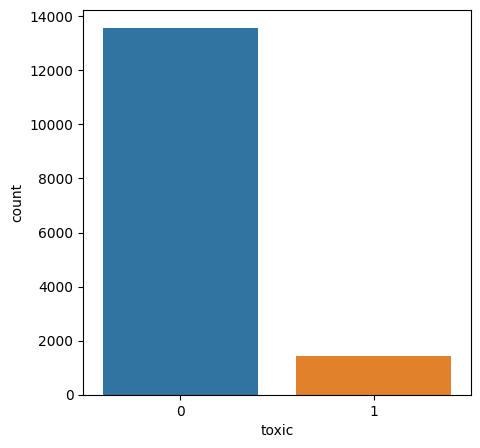

In [14]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x=train_data['toxic'],data=train_data)
plt.show()

In [15]:
test_mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/batman.png"))

In [16]:
wordcloud_text=" ".join(train_data["comment_text"].tolist())

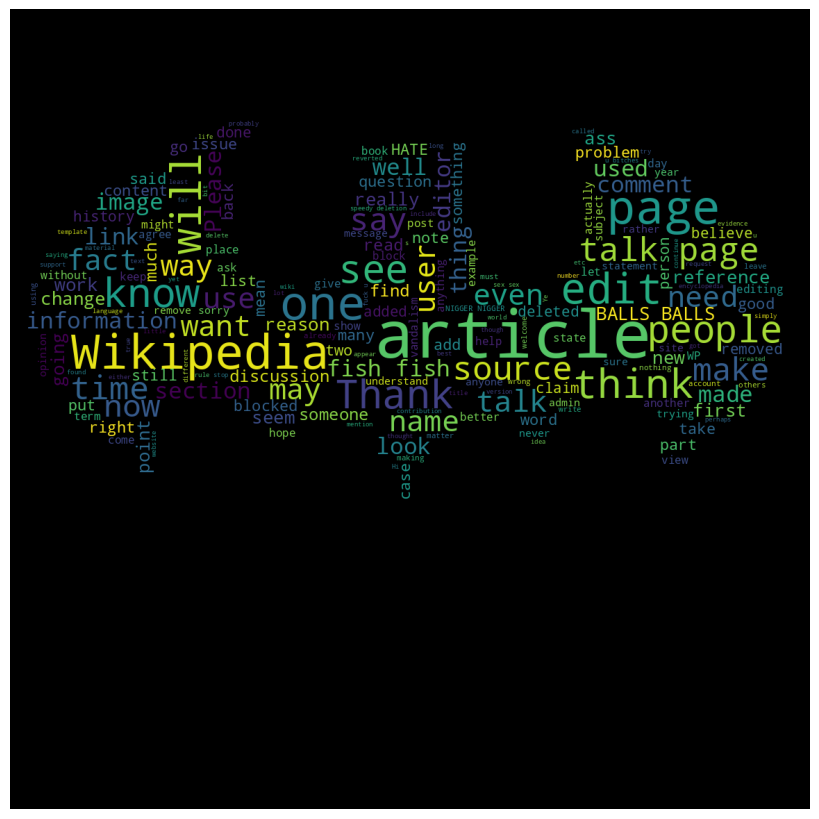

In [17]:
wordcloud=WordCloud(width=1920,height=1080,mask=test_mask).generate(wordcloud_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [18]:
train_data['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [19]:
train_data.sample(5)

,id,comment_text,toxic
3483,09634484043c49ff,"""a """"high traffic"""" one that is frequently upd...",0
5511,0eb012b6f2d8d7c8,Request to Unblock\nI began writing the follow...,1
14042,2505567b41cb745f,Megadeth article \n\nYou clearly don't get it ...,1
7466,13d9bd74d25c24c2,"""*, it looks like and have made a start on h...",0
14759,26fae3aa82d13732,At First is my observations. http://thatgrapej...,0


In [20]:
print(train_data.comment_text[20])
print(train_data.toxic[20])

"

 Regarding your recent edits 

Once again, please read WP:FILMPLOT before editing any more film articles.  Your edits are simply not good, with entirely too many unnecessary details and very bad writing.  Please stop before you do further damage. -''''''The '45 "
0


In [21]:
data_label=train_data["toxic"].values
data_text=[d.split() for d in train_data["comment_text"].tolist()]

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_text)
data_text = tokenizer.texts_to_sequences(data_text)

In [23]:
maxlen=300

In [24]:
data_text= pad_sequences(data_text,maxlen=maxlen)

In [25]:
vocab_size = len(tokenizer.word_index)+1

In [26]:
embedding_vector = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef


2196018it [03:08, 11672.97it/s]


In [27]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 91811/91811 [00:00<00:00, 351141.23it/s]


In [28]:
model=Sequential()
model.add(Embedding(vocab_size,300,input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    27,543,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,543,600 (105.07 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,543,600 (105.07 MB)

None


In [29]:
X_train,X_test,Y_train,Y_test=train_test_split(data_text,data_label,test_size=0.33,random_state=42)

In [30]:
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=10)

Epoch 1/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.9272 - loss: 0.2233 - val_accuracy: 0.9447 - val_loss: 0.1788
Epoch 2/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9511 - loss: 0.1396 - val_accuracy: 0.9487 - val_loss: 0.1480
Epoch 3/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9550 - loss: 0.1283 - val_accuracy: 0.9535 - val_loss: 0.1322
Epoch 4/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9645 - loss: 0.1058 - val_accuracy: 0.9529 - val_loss: 0.1341
Epoch 5/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9658 - loss: 0.0996 - val_accuracy: 0.9507 - val_loss: 0.1471
Epoch 6/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9763 - loss: 0.0718 - val_accuracy: 0.9531 - val_loss: 0.1525
Epoch 7/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9818 - loss: 0.0554 - val_accuracy: 0.9531 - val_loss: 0.1623
Epoch 8/10
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9891 -

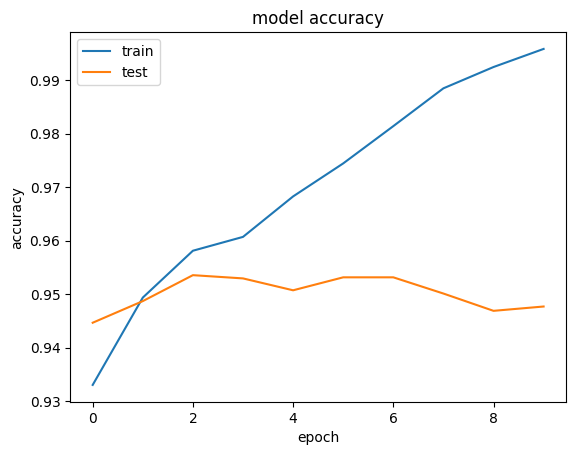

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

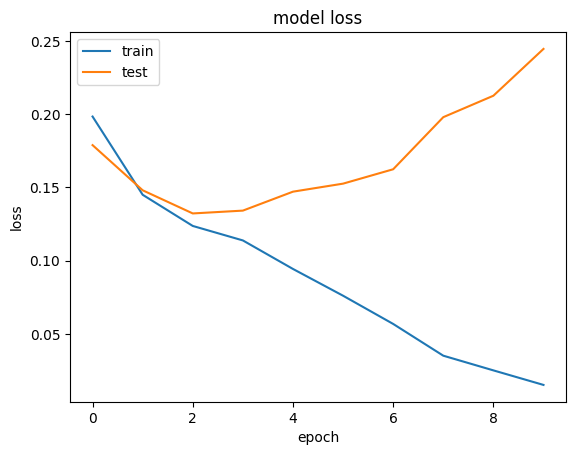

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [33]:
y_pred=(model.predict(X_test) >=0.5).astype(int)

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [34]:
accuracy_score(Y_test,y_pred)

0.947687335891739

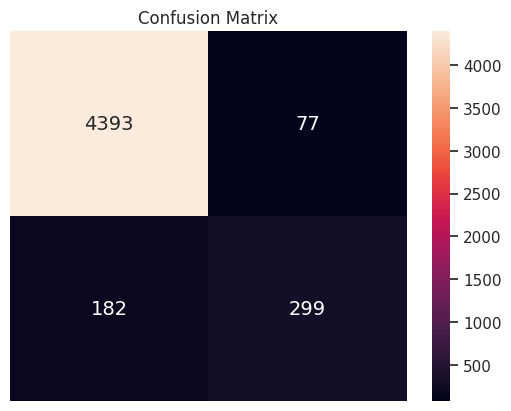

In [35]:
cm = confusion_matrix(Y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={'size':14}, fmt='d').set_title('Confusion Matrix')
plt.axis("off")
plt.show()

In [36]:
 from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4470
           1       0.80      0.62      0.70       481

    accuracy                           0.95      4951
   macro avg       0.88      0.80      0.83      4951
weighted avg       0.94      0.95      0.94      4951



In [37]:
x=["Once again, please read WP:FILMPLOT before editing any more film articles.  Your edits are simply not good, with entirely too many unnecessary details and very bad writing.  Please stop before you do further damage. -''''''The '45 "]
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [38]:
prediction=(model.predict(x) >=0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [39]:
if(prediction==1):
  print("Toxic")
else:
  print("Non Toxic")

Non Toxic
